Per fare questo lavoro serve:
- una mappa degli ospedali in  una zona (Glasgow)
- una mappa dei pazienti per postcode
- wait times per each patient
- driving time for each patient

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geodatasets

In [3]:
# 1. Load and filter population data
data_pop = pd.read_csv("OR A&E/dz2011-pop-est_21112024.csv")
data_pop.head()

C:\Users\glauc\AppData\Local\Temp\ipykernel_24972\3057801165.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_pop = pd.read_csv("OR A&E/dz2011-pop-est_21112024.csv")


,Year,DataZone,DataZoneQF,Sex,SexQF,AllAges,Age0,Age1,Age2,Age3,...,Age81,Age82,Age83,Age84,Age85,Age86,Age87,Age88,Age89,Age90plus
0,2001,S92000003,d,All,d,5064200,52027,53060,55668,56812,...,28189,18306,15594,15125,14596,13920,12341,10189,8363,29385
1,2001,S92000003,d,Female,NaN,2630467,25682,25618,27064,27742,...,18129,12064,10490,10220,10262,9843,8960,7411,6252,23018
2,2001,S92000003,d,Male,NaN,2433733,26345,27442,28604,29070,...,10060,6242,5104,4905,4334,4077,3381,2778,2111,6367
3,2001,S01006506,NaN,All,d,845,12,1,10,6,...,3,1,4,0,2,1,1,1,2,3
4,2001,S01006506,NaN,Female,NaN,423,9,1,6,2,...,3,1,4,0,0,1,1,1,1,2


In [4]:
# Filtra per anno, sesso “All” e DataZoneQF mancante (buoni dati)
data_pop = data_pop[
    (data_pop.Year == 2022) &
    (data_pop.Sex  == "All") &
    (data_pop.DataZoneQF.isna())
].copy()

# Rimuovi colonne inutili: flag + sesso + popolazione totale
data_pop.drop(columns=["DataZoneQF", "Sex", "SexQF", "AllAges"], inplace=True)

print(len(data_pop))
data_pop.head()


6976


,Year,DataZone,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7,...,Age81,Age82,Age83,Age84,Age85,Age86,Age87,Age88,Age89,Age90plus
439554,2022,S01006506,3,2,7,12,8,10,6,7,...,2,4,3,6,2,3,2,2,0,2
439557,2022,S01006507,5,10,8,8,7,6,9,9,...,9,6,4,6,5,2,3,4,2,5
439560,2022,S01006508,4,5,6,7,2,7,6,9,...,1,0,1,0,0,0,0,1,1,0
439563,2022,S01006509,3,5,3,8,4,6,6,7,...,2,3,2,6,1,2,0,1,1,9
439566,2022,S01006510,4,3,1,2,7,5,3,11,...,4,8,8,6,3,1,6,0,4,21


In [5]:
# Pivot age columns into long format
age_cols = [c for c in data_pop.columns if c.startswith("Age")]
data_pop = data_pop.melt(
    id_vars=[c for c in data_pop.columns if c not in age_cols],
    value_vars=age_cols,
    var_name="Age",
    value_name="Population"
)
# Convert Age to numeric, 90+ for NA
data_pop['Age'] = data_pop['Age'].str.replace('Age', '')
data_pop['Age'] = pd.to_numeric(data_pop['Age'], errors='coerce')
data_pop['Age'].fillna(90, inplace=True)
print(len(data_pop))
data_pop.head()

634816


C:\Users\glauc\AppData\Local\Temp\ipykernel_24972\1720810718.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_pop['Age'].fillna(90, inplace=True)


,Year,DataZone,Age,Population
0,2022,S01006506,0.0,3
1,2022,S01006507,0.0,5
2,2022,S01006508,0.0,4
3,2022,S01006509,0.0,3
4,2022,S01006510,0.0,4


In [6]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(data_pop.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((data_pop.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = data_pop.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(data_pop)}")
print()

📊 Numero di valori mancanti per colonna:
Year          0
DataZone      0
Age           0
Population    0
dtype: int64

📉 Percentuale di valori mancanti per colonna:
Year          0.0
DataZone      0.0
Age           0.0
Population    0.0
dtype: float64

⚠️ Righe con almeno un valore mancante: 0 su 634816



In [31]:
# 2. Load hospitals
data_hospital = pd.read_csv("OR A&E\hospitals.csv")
# Drop all address lines
addr_cols = [c for c in data_hospital.columns if c.startswith("AddressLine")]
data_hospital.drop(columns=addr_cols, inplace=True)
print(len(data_hospital))
data_hospital.head()

245


,HospitalCode,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,DataZone
0,A101H,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176
1,A103H,Ayrshire Central Hospital,KA128SS,S08000015,S37000020,S12000021,S02002105,S01011213
2,A110H,Lady Margaret Hospital,KA280HF,S08000015,S37000020,S12000021,S02002128,S01011328
3,A111H,University Hospital Crosshouse,KA2 0BE,S08000015,S37000008,S12000008,S02001504,S01008027
4,A114H,Warrix Avenue Mental Health Community Rehabili...,KA120DP,S08000015,S37000020,S12000021,S02002109,S01011229


In [8]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(data_hospital.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((data_hospital.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = data_hospital.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(data_hospital)}")
print()

📊 Numero di valori mancanti per colonna:
HospitalCode        0
HospitalName        0
Postcode            0
HealthBoard         0
HSCP                0
CouncilArea         0
IntermediateZone    0
DataZone            0
dtype: int64

📉 Percentuale di valori mancanti per colonna:
HospitalCode        0.0
HospitalName        0.0
Postcode            0.0
HealthBoard         0.0
HSCP                0.0
CouncilArea         0.0
IntermediateZone    0.0
DataZone            0.0
dtype: float64

⚠️ Righe con almeno un valore mancante: 0 su 245



In [32]:
# %%
# 3. Load AE activity data and clean
data_activity = pd.read_csv("OR A&E\\monthly_ae_activity_202505.csv")

# Keep only AttendanceCategory == "All"
data_activity = data_activity[data_activity.AttendanceCategory == "All"].copy()

# Drop attendance category, percentage columns, QF columns
to_drop = [c for c in data_activity.columns
           if c == 'AttendanceCategory'
           or 'Percentage' in c
           or c.endswith('QF')]

# Aggiungi le colonne che vuoi rimuovere esplicitamente
to_drop += [
    'NumberOfAttendancesEpisode',
    'NumberWithin4HoursEpisode',
    'NumberOver4HoursEpisode',
    'NumberOver8HoursEpisode',
    'NumberOver12HoursEpisode'
]

# Rimuovi le colonne
data_activity.drop(columns=to_drop, inplace=True)

# Verifica risultato
print(f"✅ Righe rimanenti: {len(data_activity)}")
print(f"📦 Colonne rimanenti: {list(data_activity.columns)}")
data_activity.head()


✅ Righe rimanenti: 18033
📦 Colonne rimanenti: ['Month', 'Country', 'HBT', 'TreatmentLocation', 'DepartmentType', 'NumberOfAttendancesAll', 'NumberWithin4HoursAll', 'NumberOver4HoursAll']


,Month,Country,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAll,NumberWithin4HoursAll,NumberOver4HoursAll
1,200707,S92000003,S08000015,A101H,Type 3,252,252,0
3,200707,S92000003,S08000015,A111H,Type 1,5414,5290,124
5,200707,S92000003,S08000015,A207H,Type 3,92,92,0
7,200707,S92000003,S08000015,A210H,Type 1,3530,3355,175
9,200707,S92000003,S08000016,B103H,Type 3,20,20,0


In [29]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(data_activity.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((data_activity.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = data_activity.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(data_activity)}")
print()

📊 Numero di valori mancanti per colonna:
Month                     0
Country                   0
HBT                       0
TreatmentLocation         0
DepartmentType            0
NumberOfAttendancesAll    0
NumberWithin4HoursAll     0
NumberOver4HoursAll       0
dtype: int64

📉 Percentuale di valori mancanti per colonna:
Month                     0.0
Country                   0.0
HBT                       0.0
TreatmentLocation         0.0
DepartmentType            0.0
NumberOfAttendancesAll    0.0
NumberWithin4HoursAll     0.0
NumberOver4HoursAll       0.0
dtype: float64

⚠️ Righe con almeno un valore mancante: 0 su 18033



In [ ]:
# %%
import numpy as np
from tqdm import tqdm  # Barra di progresso

# Copia il dataset originale
df = data_activity.copy()

# Riempie eventuali NaN con 0
df[['NumberWithin4HoursAll', 'NumberOver4HoursAll', 'NumberOfAttendancesAll']] = \
    df[['NumberWithin4HoursAll', 'NumberOver4HoursAll', 'NumberOfAttendancesAll']].fillna(0).astype(int)

# Lista per raccogliere le righe estese
patient_rows = []

# Inizializza barra di progresso
print("⏳ Generazione dei pazienti in corso...")
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    total = row['NumberOfAttendancesAll']
    n_within = row['NumberWithin4HoursAll']
    n_over = row['NumberOver4HoursAll']

    # Pazienti < 4h
    if n_within > 0:
        wait_times_within = np.random.uniform(1, 240, size=n_within).astype(int)
        for wt in wait_times_within:
            new_row = row.drop(['NumberWithin4HoursAll', 'NumberOver4HoursAll', 'NumberOfAttendancesAll']).copy()
            new_row['WaitingTime'] = wt
            patient_rows.append(new_row)

    # Pazienti > 4h
    if n_over > 0:
        wait_times_over = np.random.uniform(241, 720, size=n_over).astype(int)
        for wt in wait_times_over:
            new_row = row.drop(['NumberWithin4HoursAll', 'NumberOver4HoursAll', 'NumberOfAttendancesAll']).copy()
            new_row['WaitingTime'] = wt
            patient_rows.append(new_row)

# Costruzione del DataFrame finale
print("📦 Costruzione del DataFrame finale...")
df_patients = pd.DataFrame(patient_rows)

# Feedback finale
print(f"✅ Generazione completata: {len(df_patients):,} pazienti totali.")
df_patients.head()


KeyboardInterrupt: 

In [33]:
# 4. Merge activity with hospital info
merged_data = pd.merge(
    data_activity,
    data_hospital,
    left_on="TreatmentLocation",
    right_on="HospitalCode",
    how="left"
)
print(len(merged_data))
merged_data.head()


18033


,Month,Country,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAll,NumberWithin4HoursAll,NumberOver4HoursAll,HospitalCode,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,DataZone
0,200707,S92000003,S08000015,A101H,Type 3,252,252,0,A101H,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176
1,200707,S92000003,S08000015,A111H,Type 1,5414,5290,124,A111H,University Hospital Crosshouse,KA2 0BE,S08000015,S37000008,S12000008,S02001504,S01008027
2,200707,S92000003,S08000015,A207H,Type 3,92,92,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200707,S92000003,S08000015,A210H,Type 1,3530,3355,175,A210H,University Hospital Ayr,KA6 6DX,S08000015,S37000027,S12000028,S02002333,S01012444
4,200707,S92000003,S08000016,B103H,Type 3,20,20,0,B103H,The Knoll Hospital,TD113EL,S08000016,S37000025,S12000026,S02002304,S01012305


In [34]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(merged_data.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((merged_data.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = merged_data.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(merged_data)}")
print()

📊 Numero di valori mancanti per colonna:
Month                        0
Country                      0
HBT                          0
TreatmentLocation            0
DepartmentType               0
NumberOfAttendancesAll       0
NumberWithin4HoursAll        0
NumberOver4HoursAll          0
HospitalCode              1460
HospitalName              1460
Postcode                  1460
HealthBoard               1460
HSCP                      1460
CouncilArea               1460
IntermediateZone          1460
DataZone                  1460
dtype: int64

📉 Percentuale di valori mancanti per colonna:
Month                     0.0
Country                   0.0
HBT                       0.0
TreatmentLocation         0.0
DepartmentType            0.0
NumberOfAttendancesAll    0.0
NumberWithin4HoursAll     0.0
NumberOver4HoursAll       0.0
HospitalCode              8.1
HospitalName              8.1
Postcode                  8.1
HealthBoard               8.1
HSCP                      8.1
CouncilArea  

In [ ]:
print(data_pop["DataZone"].nunique(), merged_data["DataZone"].nunique())
print(data_pop["DataZone"].unique()[:5])
print(merged_data["DataZone"].unique()[:5])


6976 85
['S01006506' 'S01006507' 'S01006508' 'S01006509' 'S01006510']
['S01011176' 'S01008027' nan 'S01012444' 'S01012305']


In [14]:
# 5. Join with population data (right join to keep all population zones)
final_data = pd.merge(
    merged_data,
    data_pop,
    on="DataZone",
    how="right"
)
print(len(final_data))
final_data.head()

2135224


,Month,Country,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAll,NumberWithin4HoursAll,NumberOver4HoursAll,NumberOfAttendancesEpisode,NumberWithin4HoursEpisode,...,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,DataZone,Year,Age,Population
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S01006506,2022,0.0,3
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S01006507,2022,0.0,5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S01006508,2022,0.0,4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S01006509,2022,0.0,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S01006510,2022,0.0,4


In [15]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(final_data.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((final_data.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = final_data.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(final_data)}")
print()

📊 Numero di valori mancanti per colonna:
Month                          627081
Country                        627081
HBT                            627081
TreatmentLocation              627081
DepartmentType                 627081
NumberOfAttendancesAll         627081
NumberWithin4HoursAll          627081
NumberOver4HoursAll            627081
NumberOfAttendancesEpisode    1280734
NumberWithin4HoursEpisode     1280734
NumberOver4HoursEpisode       1280734
NumberOver8HoursEpisode       1280734
NumberOver12HoursEpisode      1280734
HospitalCode                   627081
HospitalName                   627081
Postcode                       627081
HealthBoard                    627081
HSCP                           627081
CouncilArea                    627081
IntermediateZone               627081
DataZone                            0
Year                                0
Age                                 0
Population                          0
dtype: int64

📉 Percentuale di valori mancanti 

In [16]:
# 6. Filter to specific months
months = [
    "202406","202407","202408","202409","202410",
    "202411","202412","202501","202502","202503",
    "202504","202505"
]
final_data2 = final_data[final_data.Month.isin(months)]
len(final_data2)

0

In [35]:
final_data = pd.read_csv("OR A&E\FINAL_DATA.csv")
final_data.head()

,Unnamed: 0,Month,Country,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAll,NumberWithin4HoursAll,NumberOver4HoursAll,NumberOfAttendancesEpisode,...,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,DataZone,AllAges,Age,Population
0,1441888,202406,S92000003,S08000015,A101H,Type 3,362,355,7,NaN,...,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,0,2.0
1,1441889,202406,S92000003,S08000015,A101H,Type 3,362,355,7,NaN,...,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,1,5.0
2,1441890,202406,S92000003,S08000015,A101H,Type 3,362,355,7,NaN,...,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,2,3.0
3,1441891,202406,S92000003,S08000015,A101H,Type 3,362,355,7,NaN,...,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,3,5.0
4,1441892,202406,S92000003,S08000015,A101H,Type 3,362,355,7,NaN,...,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,4,3.0


In [37]:
# %%
# 1. Drop columns with many NaN values
cols_to_drop = [
    'NumberOfAttendancesEpisode',
    'NumberWithin4HoursEpisode',
    'NumberOver4HoursEpisode',
    'NumberOver8HoursEpisode',
    'NumberOver12HoursEpisode'
]
final_data.drop(columns=cols_to_drop, inplace=True)

print(f"🗑️ Colonne rimosse: {cols_to_drop}")

# %%
# 2. Drop rows with remaining NaN values
initial_len = len(final_data)
final_data.dropna(inplace=True)
final_len = len(final_data)

print(f"✅ Righe rimosse: {initial_len - final_len}")
print(f"📦 Righe finali: {final_len}")


🗑️ Colonne rimosse: ['NumberOfAttendancesEpisode', 'NumberWithin4HoursEpisode', 'NumberOver4HoursEpisode', 'NumberOver8HoursEpisode', 'NumberOver12HoursEpisode']
✅ Righe rimosse: 12
📦 Righe finali: 67704


In [38]:
# Controlla il numero di NaN per ogni colonna
print("📊 Numero di valori mancanti per colonna:")
print(final_data.isna().sum())
print()

# Percentuale di NaN per colonna (utile se ci sono molte righe)
print("📉 Percentuale di valori mancanti per colonna:")
print((final_data.isna().mean() * 100).round(2))
print()

# Quante righe hanno almeno un NaN
nan_rows = final_data.isna().any(axis=1).sum()
print(f"⚠️ Righe con almeno un valore mancante: {nan_rows} su {len(final_data)}")
print()

📊 Numero di valori mancanti per colonna:
Unnamed: 0                0
Month                     0
Country                   0
HBT                       0
TreatmentLocation         0
DepartmentType            0
NumberOfAttendancesAll    0
NumberWithin4HoursAll     0
NumberOver4HoursAll       0
HospitalName              0
Postcode                  0
HealthBoard               0
HSCP                      0
CouncilArea               0
IntermediateZone          0
DataZone                  0
AllAges                   0
Age                       0
Population                0
dtype: int64

📉 Percentuale di valori mancanti per colonna:
Unnamed: 0                0.0
Month                     0.0
Country                   0.0
HBT                       0.0
TreatmentLocation         0.0
DepartmentType            0.0
NumberOfAttendancesAll    0.0
NumberWithin4HoursAll     0.0
NumberOver4HoursAll       0.0
HospitalName              0.0
Postcode                  0.0
HealthBoard               0.0
HSCP   

In [ ]:
final_data.head()
# Month, Country, 

,Unnamed: 0,Month,Country,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAll,NumberWithin4HoursAll,NumberOver4HoursAll,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,DataZone,AllAges,Age,Population
0,1441888,202406,S92000003,S08000015,A101H,Type 3,362,355,7,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,0,2.0
1,1441889,202406,S92000003,S08000015,A101H,Type 3,362,355,7,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,1,5.0
2,1441890,202406,S92000003,S08000015,A101H,Type 3,362,355,7,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,2,3.0
3,1441891,202406,S92000003,S08000015,A101H,Type 3,362,355,7,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,3,5.0
4,1441892,202406,S92000003,S08000015,A101H,Type 3,362,355,7,Arran War Memorial Hospital,KA278LF,S08000015,S37000020,S12000021,S02002097,S01011176,552.0,4,3.0


In [42]:
# 8. Spatial join with datazone boundaries
dz = gpd.read_file("OR A&E\Shapefiles\SG_DataZone_Bdry_2011.shp")
selected = dz[dz.DataZone.isin(final_data.DataZone)]
final_sf = selected.merge(final_data, on="DataZone", how="left")

In [43]:
final_sf.head()

,DataZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area,geometry,...,NumberOver4HoursAll,HospitalName,Postcode,HealthBoard,HSCP,CouncilArea,IntermediateZone,AllAges,Age,Population
0,S01006563,Midstocket - 06,826,824,366,64.901189,0.649014,4986.398167,649011.882991,"POLYGON ((392425 807470, 392431 807330, 392431...",...,2523,Aberdeen Royal Infirmary,AB252ZN,S08000020,S37000001,S12000033,S02001245,874.0,0,5.0
1,S01006563,Midstocket - 06,826,824,366,64.901189,0.649014,4986.398167,649011.882991,"POLYGON ((392425 807470, 392431 807330, 392431...",...,2523,Aberdeen Royal Infirmary,AB252ZN,S08000020,S37000001,S12000033,S02001245,874.0,1,4.0
2,S01006563,Midstocket - 06,826,824,366,64.901189,0.649014,4986.398167,649011.882991,"POLYGON ((392425 807470, 392431 807330, 392431...",...,2523,Aberdeen Royal Infirmary,AB252ZN,S08000020,S37000001,S12000033,S02001245,874.0,2,7.0
3,S01006563,Midstocket - 06,826,824,366,64.901189,0.649014,4986.398167,649011.882991,"POLYGON ((392425 807470, 392431 807330, 392431...",...,2523,Aberdeen Royal Infirmary,AB252ZN,S08000020,S37000001,S12000033,S02001245,874.0,3,11.0
4,S01006563,Midstocket - 06,826,824,366,64.901189,0.649014,4986.398167,649011.882991,"POLYGON ((392425 807470, 392431 807330, 392431...",...,2523,Aberdeen Royal Infirmary,AB252ZN,S08000020,S37000001,S12000033,S02001245,874.0,4,9.0


C:\Users\glauc\AppData\Local\Temp\ipykernel_24972\2117819155.py:21: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\glauc\Desktop\PHS\env_phs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


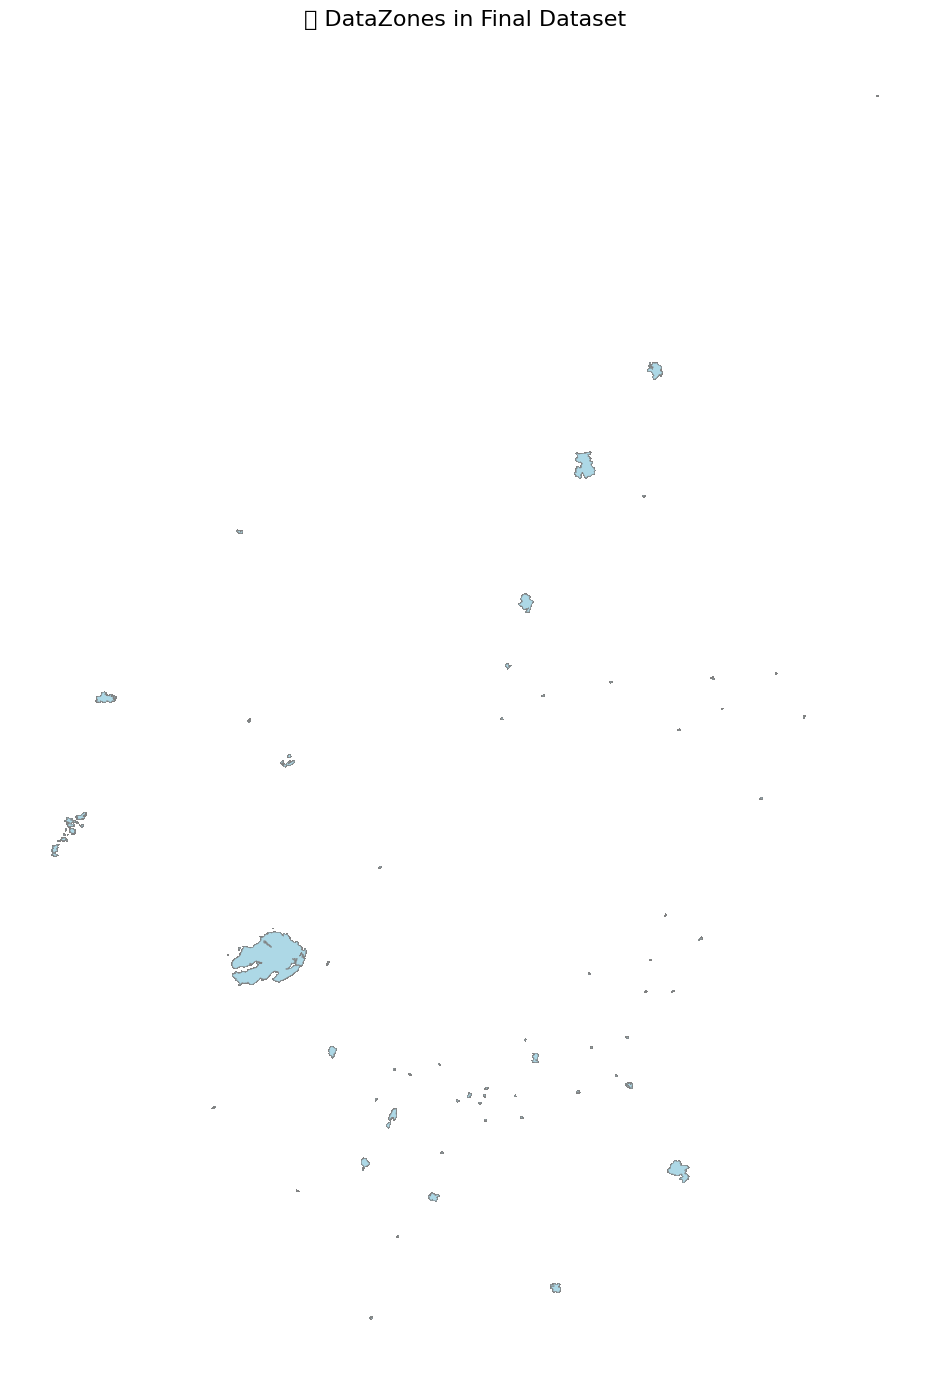

In [44]:
# %% [markdown]
# 📍 Plot delle DataZones contenute in final_sf

# %% 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 14))

# Disegna i poligoni delle DataZone
final_sf.plot(
    ax=ax,
    color="lightblue",
    edgecolor="gray",
    linewidth=0.3
)

# Titolo e stile
ax.set_title("🗺️ DataZones in Final Dataset", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [19]:
# 9. Compute average population per zone
geom_data = final_sf.dissolve(
    by='DataZone',
    aggfunc={'Population': 'mean'}
)

c:\Users\glauc\Desktop\PHS\env_phs\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


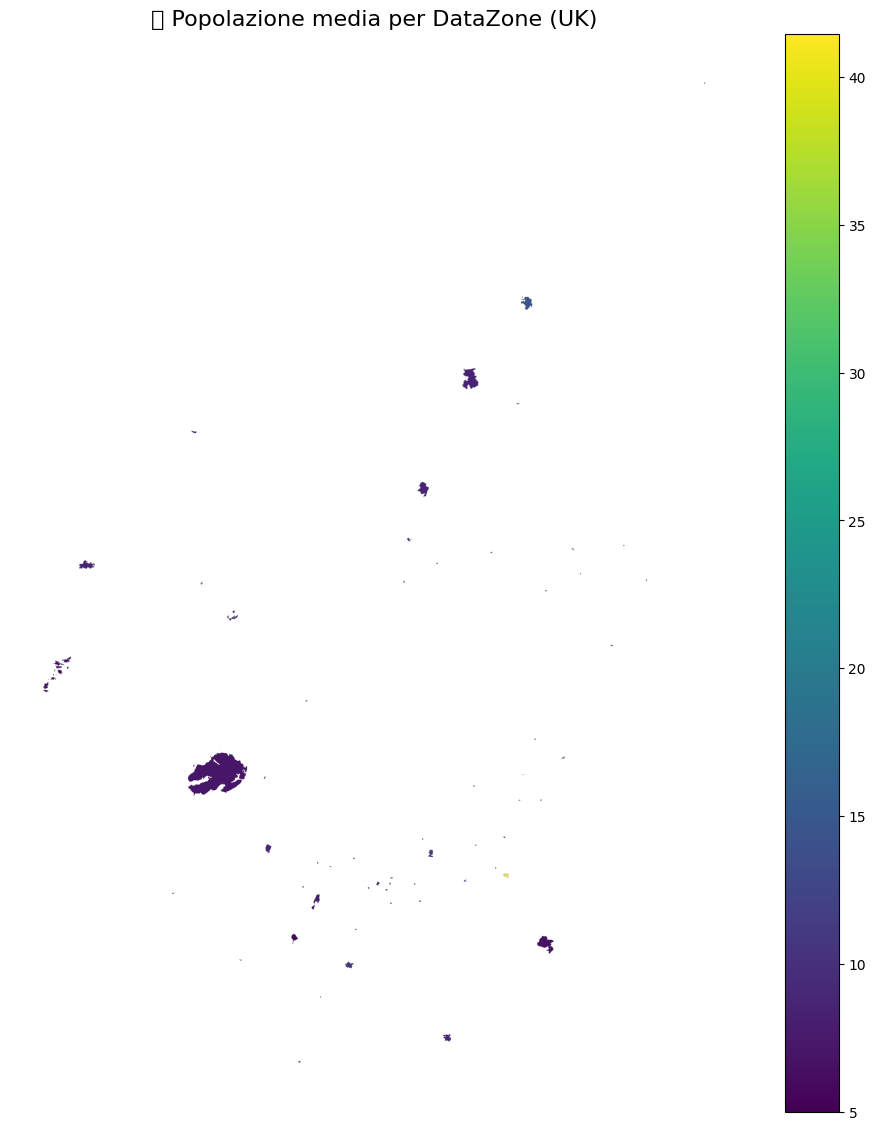

In [27]:
# %%
# 10. Imposta CRS e resetta indice
geom_data = geom_data.reset_index()
geom_data = geom_data.set_geometry('geometry')
geom_data.crs = dz.crs  # assicurati che il sistema di riferimento sia corretto

# %%
# 11. Traccia la mappa colorando per popolazione media
fig, ax = plt.subplots(1, 1, figsize=(12, 14))
geom_data.plot(
    column='Population',
    cmap='viridis',        # Puoi anche provare 'OrRd', 'plasma', 'YlGnBu', ecc.
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title("📍 Popolazione media per DataZone (UK)", fontsize=16)
ax.set_axis_off()
plt.show()
